# Twitter archive analysis in R
This performs some twitter archive analysis that is [based on this chapter of *Text Mining with R*](https://www.tidytextmining.com/twitter.html). 

For a start let's install all the required packages again:

In [1]:
library(purrr)
library(stringr)
library(tidytext)
library(widyr)
library(httr)
library(lubridate)
library(ggplot2)
library(dplyr)
library(readr)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘dplyr’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Let's now get our access token and request our personal user object that will contain all of our data file downloads etc.:

In [2]:
access_token <- Sys.getenv("OH_ACCESS_TOKEN")
url <- paste("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token=",access_token,sep="")
resp <- GET(url)
user <- content(resp, "parsed")

Let's now look at the data sources we have on Open Humans:

In [3]:
# user$data

Let's now find the download URL for the Twitter archive from all files:

In [4]:
for (data_source in user$data){
    if (data_source$source == "direct-sharing-70"){
         twitter_archive_url <- data_source$download_url
    }
}

We can now create a temporary file that will contain the whole zipped Twitter archivee, from this we can then unzip and read the `tweets.csv` file:

In [5]:
temp <- tempfile()
download.file(twitter_archive_url,temp,method='wget')

#unzip(temp, list=TRUE) # this would list all files in the zip archive

data <- read_csv(unz(temp, "tweets.csv"))


Parsed with column specification:
cols(
  tweet_id = col_double(),
  in_reply_to_status_id = col_double(),
  in_reply_to_user_id = col_double(),
  timestamp = col_character(),
  source = col_character(),
  text = col_character(),
  retweeted_status_id = col_double(),
  retweeted_status_user_id = col_double(),
  retweeted_status_timestamp = col_character(),
  expanded_urls = col_character()
)


Now let's convert the timestamps into a proper format and plot a simple histogram of tweets over time:

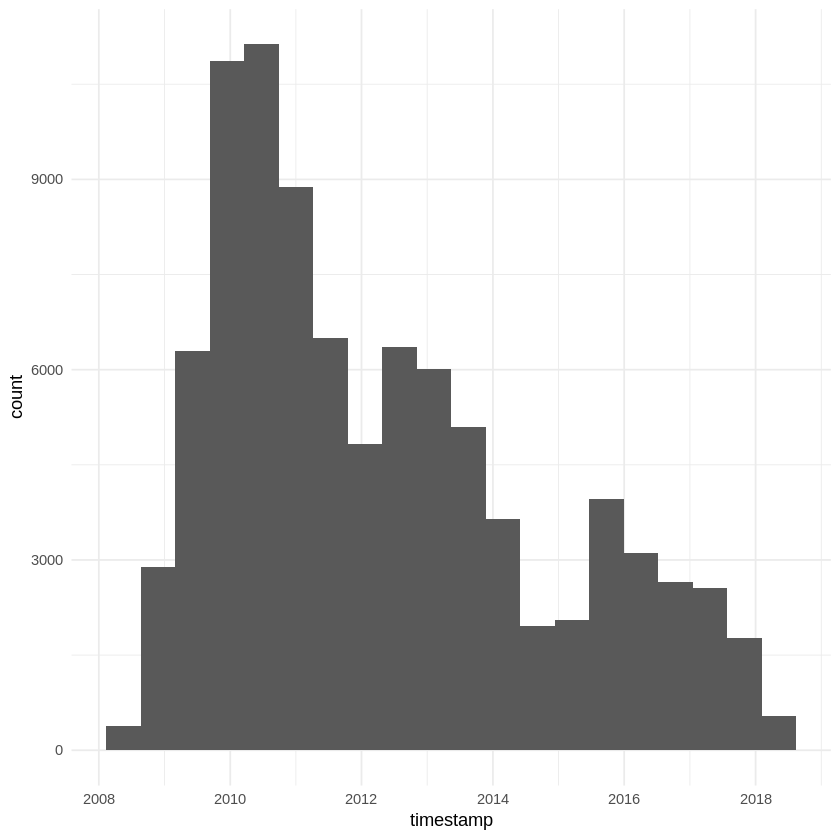

In [6]:
tweets <- mutate(data,timestamp = ymd_hms(timestamp))
ggplot(tweets, aes(x = timestamp)) +
  geom_histogram(position = "identity", bins = 20, show.legend = FALSE) + theme_minimal()

We can now tokenize the tweet texts, which will make it easier to work with and also allows us to easily calculate word frequencies in the next step: 

In [7]:
replace_reg <- "https://t.co/[A-Za-z\\d]+|http://[A-Za-z\\d]+|&amp;|&lt;|&gt;|RT|https"
unnest_reg <- "([^A-Za-z_\\d#@']|'(?![A-Za-z_\\d#@]))"
tidy_tweets <- tweets %>% 
  filter(!str_detect(text, "^RT")) %>%
  mutate(text = str_replace_all(text, replace_reg, "")) %>%
  unnest_tokens(word, text, token = "regex", pattern = unnest_reg) %>%
  filter(!word %in% stop_words$word,
         str_detect(word, "[a-z]"))

frequency <- tidy_tweets %>% 
  count(word, sort = TRUE) 
frequency$freq <- frequency$n / sum(frequency$n)

So, what's the top words I used over time: Yep, that would be the German equivalents of `I`, all the articles (`der, die, das`) along with `not` and `is`.

In [8]:
head(frequency)

word,n,freq
ich,17749,0.02300768
die,12838,0.01664165
das,12081,0.01566036
der,9146,0.01185578
nicht,8669,0.01123746
ist,8501,0.01101968


Let's now group the tweets by being "old" (pre-2013) and more recent ones (2013 or newer) to see whether the topics I tweet about have changed. After grouping we can calulcate the word-ratios and look at the most dividing and the most recent words:

In [9]:
library(tidyr)

tidy_tweets$date_group <- ifelse(tidy_tweets$timestamp < as.Date("2013-01-01"),"past","today")

word_ratios <- tidy_tweets %>%
  filter(!str_detect(word, "^@")) %>%
  count(word, date_group) %>%
  filter(sum(n) >= 10) %>%
  ungroup() %>%
  spread(date_group, n, fill = 0) %>%
  mutate_if(is.numeric, funs((. + 1) / sum(. + 1))) %>%
  mutate(logratio = log(past / today)) %>%
  arrange(desc(logratio))

word_ratios %>% 
  arrange(abs(logratio))

word,past,today,logratio
option,8.071251e-05,8.071286e-05,-4.282714e-06
backup,4.447424e-05,4.439207e-05,1.849286e-03
ern,4.447424e-05,4.439207e-05,1.849286e-03
gefallen,7.247654e-05,7.264157e-05,-2.274431e-03
timeline,1.087148e-04,1.089624e-04,-2.274431e-03
wieviel,3.623827e-05,3.632079e-05,-2.274431e-03
haha,2.091936e-04,2.098534e-04,-3.148939e-03
extra,5.271021e-05,5.246336e-05,4.694238e-03
spam,1.054204e-04,1.049267e-04,4.694238e-03
videos,6.424057e-05,6.457028e-05,-5.119383e-03


We can see that some things, e.g. `archives` haven't changed much in frequency, as obvious from the small "odds" ratio that's close to zero. Outliers with a large positive values are those that were more frequent in the past, while outliers with values large negative values are more common in more recent tweets. To make it a bit more intuitive we can now plot the Top 15 words with the largest positive/negative odds ratio: 

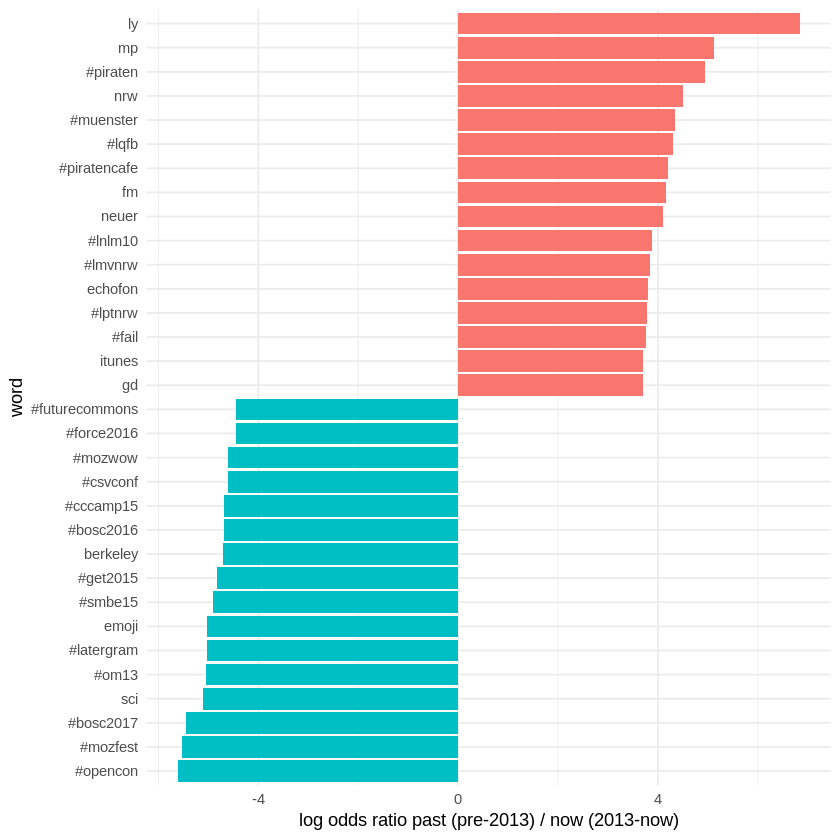

In [10]:
word_ratios %>%
  group_by(logratio < 0) %>%
  top_n(15, abs(logratio)) %>%
  ungroup() %>%
  mutate(word = reorder(word, logratio)) %>%
  ggplot(aes(word, logratio, fill = logratio < 0)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  ylab("log odds ratio past (pre-2013) / now (2013-now)") +
  scale_fill_discrete(name = "", labels = c("past", "now")) + theme_minimal()

What we see: My activity in the Pirate Party (and living in the state of North-Rhine Westphalia - short `NRW`) is clearly in the past and tweets about them occur mainly before 2013 - as demonstrated by hashtags like `#piraten, #lptnrw, #lmvnrw, #nrw` etc. My activity in the Open Science world is clearly still going strong in comparison: `#opencon, #mozfest, bosc201*, #csvconf` etc. are overrepresented. But what would happen if we excluded hashtags?

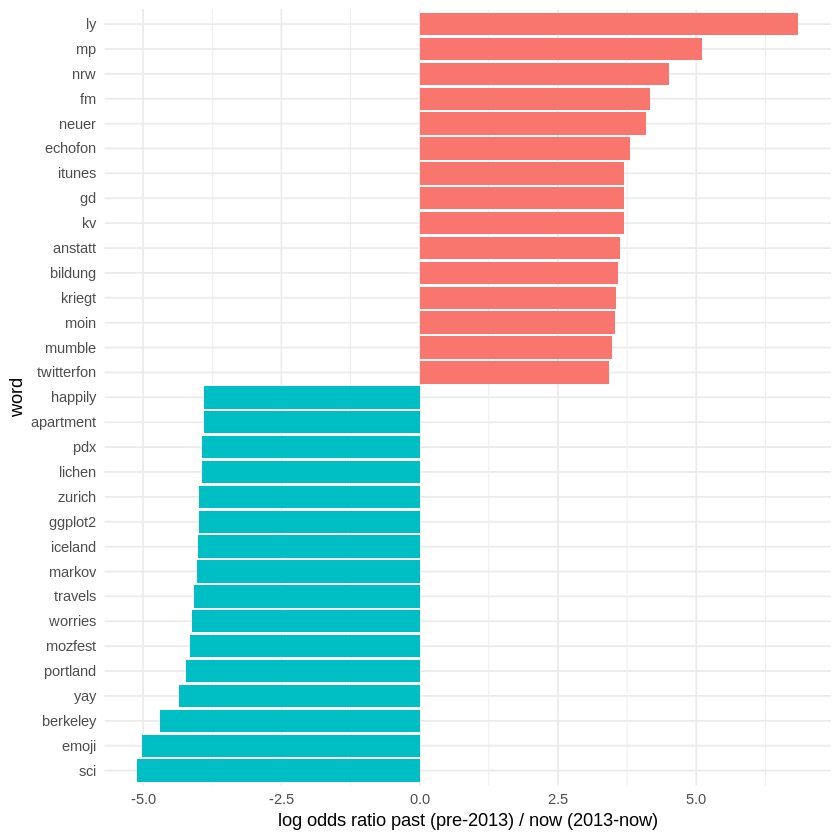

In [11]:
word_ratios %>%
  filter(!str_detect(word, "^#")) %>%
  group_by(logratio < 0) %>%
  top_n(15, abs(logratio)) %>%
  ungroup() %>%
  mutate(word = reorder(word, logratio)) %>%
  ggplot(aes(word, logratio, fill = logratio < 0)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  ylab("log odds ratio past (pre-2013) / now (2013-now)") +
  scale_fill_discrete(name = "", labels = c("past", "now")) + theme_minimal()

This looks a bit different, now older words are somewhat associated with the German language/dialects (`moin, kriegt, bildung, anstatt, neuer`) and random Top-Level-Domains that have fallen out of popularity (`ly, fm`) while the newer trends are 

- english speaking (`yay, travels, happily, worries`) 
- location based (`portland, berkeley, iceland, zurich`), fitting an increased travel compared to earlier times
- phd-related (`lichens, ggplot2, markov`) 
- and modern-ish inventions. `emoji` anyone? 😂

And now let's do the whole thing by just looking at people I replied to in the past compared to now:

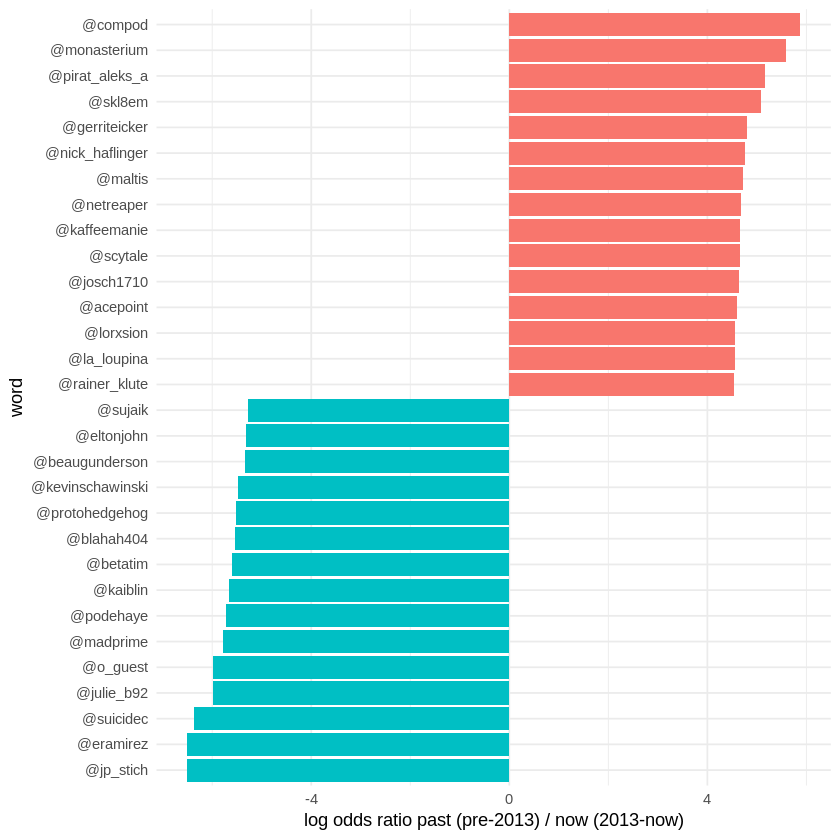

In [12]:
tidy_tweets %>%
  filter(str_detect(word, "^@")) %>%
  filter(!str_detect(word, "^@ny")) %>%
  count(word, date_group) %>%
  filter(sum(n) >= 10) %>%
  ungroup() %>%
  spread(date_group, n, fill = 0) %>%
  mutate_if(is.numeric, funs((. + 1) / sum(. + 1))) %>%
  mutate(logratio = log(past / today)) %>%
  arrange(desc(logratio)) %>%
  group_by(logratio < 0) %>%
  top_n(15, abs(logratio)) %>%
  ungroup() %>%
  mutate(word = reorder(word, logratio)) %>%
  ggplot(aes(word, logratio, fill = logratio < 0)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  ylab("log odds ratio past (pre-2013) / now (2013-now)") +
  scale_fill_discrete(name = "", labels = c("past", "now")) + theme_minimal()


People from the past are largely other Pirate Party members. People from the present heavily feature the Open* & Quantified Self crowd at large (e.g. `@o_guest, @sujaik, @protohedgehog, @kevinschawinski, @kaiblin, @eramirez`), including some of the awesome people that run/ran `Open Humans` with me to make this possible (👋 `beaugunderson, @madprime, @betatim`).

## Emoji pairings
In a next step we can now look into highly-frequent pairings of emoji with individual words. For this we filter out the emoji out of all tweet-texts and associate them with words, ignoring stop-words & URLs etc.

In [13]:
emoji_tweets <- tweets %>%
  filter(!str_detect(text, "^RT")) %>%
  filter(!str_detect(text, "^@")) %>%
  filter(str_detect(text, "[\\uD83C-\\uDBFF\\uDC00-\\uDFFF]+")) %>%
  mutate(Emoji = str_extract_all(text, 
                  "[\\uD83C-\\uDBFF\\uDC00-\\uDFFF]+")) %>%
  select(tweet_id, timestamp, Emoji,text) 

In [14]:
emoji_tweets <- emoji_tweets %>%
  select(-Emoji) %>%
  unnest_tokens(word, text) %>%
  left_join(emoji_tweets) %>%
  mutate(Emoji = map_chr(Emoji, ~ ifelse(length(.x) > 0, .x[[1]], ""))) %>%
  mutate(word = str_replace_all(word, "’", "'")) %>%
  filter(!(Emoji %in% c("", "-"))) %>%
  filter(!(word %in% c("t.co", "http",'https'))) %>%
  filter(!word %in% stop_words$word,
         str_detect(word, "[a-z]"))

Joining, by = c("tweet_id", "timestamp")


In [15]:
emo_twids <- emoji_tweets %>%
  select(tweet_id, Emoji) %>%
  distinct() %>%
  rename(word = Emoji)
  
emoji_tweets %>%
  select(tweet_id, word) %>%
  bind_rows(emo_twids) %>%
  pairwise_count(word, tweet_id, sort = TRUE) %>%
  filter(item1 %in% unique(emoji_tweets$Emoji)) %>%
  group_by(item1) %>%
  slice(1:2) %>%
  ungroup() %>%
  filter(nchar(item2) > 2) %>%
  arrange(desc(n)) %>% head(n=10)

item1,item2,n
️,fra,31
🎉,opensnp,9
️,lhr,8
😂,data,7
😂,opencon,6
🎉,humans,4
😍,mozfest,4
🍻,beer,3
🐶,dog,3
💖,hear,3


Looking at the top 10 emoji we find that #mozfest is more 😍, while #opencon is more 😂. And there's two words, `fra` and `lhr` where the emoji can't be rendered by `R`. This would be ✈️, which associates with the IATA codes for the Frankfurt airport and London Heathrow. 